Connected to work (Python 3.10.13)

In [17]:
import yaml
import numpy as np
import models
import torch
import os
import matplotlib.pyplot as plt
from datasets import MelDataset
from torch.utils.data import DataLoader


# load path
os.chdir('/mnt/work/')


# test data loader
data_config_path = "./Animal/configs/monkey/dataset1.yaml"
data_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
tst_set = MelDataset(data_config, used_key = ['twin_1'], subset='test')
tst_single_sampler = DataLoader(tst_set, batch_size=1, shuffle=True)


# load model test
model_config = './Animal/configs/monkey/model1.yaml'
model_config = yaml.load(open(model_config, "r"), Loader=yaml.FullLoader)
model_type = getattr(models, model_config['model_name'])
device = 'cpu'
model = model_type(model_config, device)


# # load model
# exp_name = 'VAEbase-highindiweight-c_100.0_1.3-i_50.0_60.0'
# model_path = 'Animal/output'
# save_path = os.path.join(model_path, exp_name, 'checkpoint', "70000.pth.tar")
# ckpt = torch.load(save_path)
# model.load_state_dict(ckpt["model"])
# print('model_name:',model_config['model_name'])



100%|██████████| 4835/4835 [00:02<00:00, 1810.03it/s]


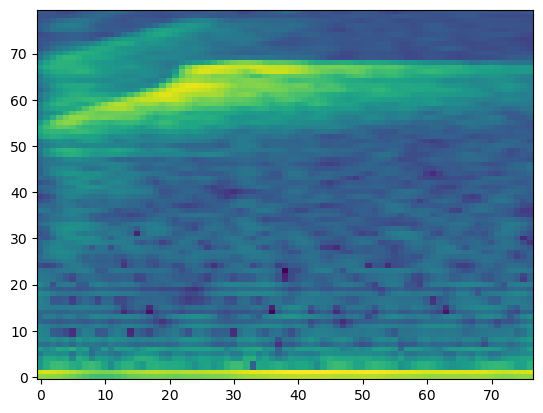

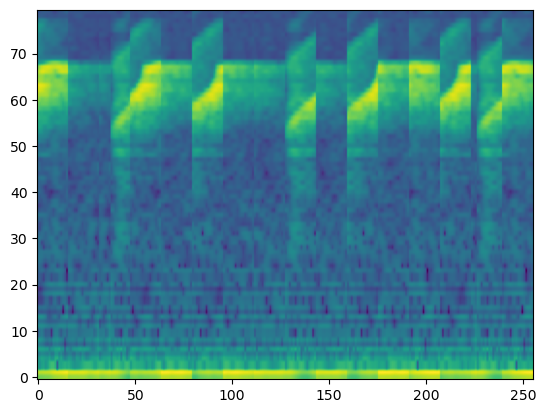

In [18]:


# data for input 
val_mel, val_lenx, val_indi_mel, val_ctID, val_cID = next(iter(tst_single_sampler))
# x = torch.ones(1,80,200)
# lenx = torch.tensor(x.shape[-1]).unsqueeze(0)
# indi_ref = torch.ones(1,80,256)

def plt_fre(x):
    plt.imshow(x, aspect='auto', origin='lower')
    plt.show()

val_mel = val_mel[0].detach().numpy()
plt_fre(val_mel)

val_indi_mel = val_indi_mel[0].detach().numpy()
plt_fre(val_indi_mel)

# out = model(val_mel, val_lenx, val_indi_mel)




# para
# total_params = sum(p.numel() for p in model.parameters())
# for key, value in out.items():
#     print(key, value.shape)

In [1]:
import yaml
import numpy as np
import models
import torch
import os
import matplotlib.pyplot as plt
from datasets import MelDataset, vctkDataset, greatbirdDataset
from torch.utils.data import DataLoader


# load path
os.chdir('/mnt/work/')
EPS = 1e-12

# test data loader
data_config_path = "./Animal/configs/monkey/dataset4.yaml"
data_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
tst_set = MelDataset(data_config, used_key = [['calltype_1'],['twin_1_0']], subset='test')
tst_single_sampler = DataLoader(tst_set, batch_size=1, shuffle=True)

# JVAE
model_config = './Animal/configs/greatbird/model_greatbird_JVAE.yaml'
model_config = yaml.load(open(model_config, "r"), Loader=yaml.FullLoader)

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

# data for input
mel, lenx, indi_mel, ctID, cID= next(iter(tst_single_sampler))
mel = mel.to(device)
lenx = lenx.to(device)
indi_mel = indi_mel.to(device)
                 
# outputs 
outputs = model(mel, lenx, indi_mel) 



def _kl_multiple_discrete_loss(alphas):
    """
    Calculates the KL divergence between a set of categorical distributions
    and a set of uniform categorical distributions.

    Parameters
    ----------
    alphas : list
        List of the alpha parameters of a categorical (or gumbel-softmax)
        distribution. For example, if the categorical atent distribution of
        the model has dimensions [2, 5, 10] then alphas will contain 3
        torch.Tensor instances with the parameters for each of
        the distributions. Each of these will have shape (N, D).
    """
    # Calculate kl losses for each discrete latent
    kl_losses = [_kl_discrete_loss(alpha) for alpha in alphas]

    # Total loss is sum of kl loss for each discrete latent
    kl_loss = torch.sum(torch.cat(kl_losses))

    # Record losses
    # if self.model.training and self.num_steps % self.record_loss_every == 1:
    #     self.losses['kl_loss_disc'].append(kl_loss.item())
    #     for i in range(len(alphas)):
    #         self.losses['kl_loss_disc_' + str(i)].append(kl_losses[i].item())

    return kl_loss


def _kl_discrete_loss(alpha):
    """
    Calculates the KL divergence between a categorical distribution and a
    uniform categorical distribution.

    Parameters
    ----------
    alpha : torch.Tensor
        Parameters of the categorical or gumbel-softmax distribution.
        Shape (N, D)
    """
    disc_dim = int(alpha.size()[-1])
    log_dim = torch.Tensor([np.log(disc_dim)])
    if True:
        log_dim = log_dim.to(device)
    # Calculate negative entropy of each row
    
    aaa = alpha * torch.log(alpha + EPS)
    bbb = torch.sum(aaa, dim=1)
    
    t_tensor = torch.full((1, 256), 1/256)
    t_tensor[0, 0] = 0.9
    remaining_sum = 1.0 - 0.9
    t_tensor[0, 1:] = (remaining_sum / (256 - 1))
    
    zzz = t_tensor * torch.log(t_tensor + EPS)
    zzz_2 = torch.sum(zzz, dim=1)
    
    
    neg_entropy = torch.sum(alpha * torch.log(alpha + EPS), dim=1)
    # Take mean of negative entropy across batch
    mean_neg_entropy = torch.mean(neg_entropy, dim=0)
    # KL loss of alpha with uniform categorical variable
    kl_loss = log_dim + mean_neg_entropy
    
    return kl_loss

sum_input = torch.sum(outputs['latent_dist']['disc'][0]) 
kl_disc_loss = _kl_multiple_discrete_loss(outputs['latent_dist']['disc'])


dataset marmoset loading...
Dict_1 ['calltype_1']
Dict_2 ['twin_1_0']


100%|██████████| 625/625 [00:06<00:00, 98.35it/s] 
